In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.0f}'.format)

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set global seaborn theme with black background
sns.set_theme(
    context='notebook',
    style='darkgrid',
    palette='dark',
    font='DejaVu Sans',
    rc={
        'axes.facecolor': 'black',        # plot background
        'figure.facecolor': 'black',      # figure background
        'grid.color': '#1A1A1A',        # dark deep gray grid lines
        'axes.edgecolor': 'white',        # axis lines color (we'll make top/right invisible)
        'xtick.color': 'white',
        'ytick.color': 'white',
        'text.color': 'white'
    },
    color_codes=True
)

def custom_theme(ax, title, xlabel, ylabel='Frequency'):
    # Set title and labels
    ax.set_title(title, fontsize=18, fontweight='bold', color='white')
    ax.set_xlabel(xlabel, fontsize=14, fontweight='bold', color='white')
    ax.set_ylabel(ylabel, fontsize=14, fontweight='bold', color='white')
    ax.tick_params(axis='both', which='major', labelsize=12, colors='white')

    # Hide top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    # Keep left and bottom spines subtle
    ax.spines['left'].set_color('#333333')
    ax.spines['bottom'].set_color('#333333')

# Define a color for each property type
colors = {
    'building': '#3E64FF',
    'villa': '#FF6B6B',
    'unit': '#44CFCB',
    'land': '#F4A261'
}

type_order = ['unit', 'villa', 'building', 'land']  # fixed order

### Data Preparation

In [5]:
df = pd.read_csv('./data/processed/transactions_clean.csv')
units = df[df['property_type'] == 'unit'].reset_index(drop=True)

In [6]:
units = units[units['trans_group'] == 'sales']
units = units[units['property_sub_type'] == 'flat']

In [7]:
units = units[units['rooms'].notna()]
units = units[~units['rooms'].isin(['Shop', 'Office'])]
units.loc[units['rooms'] == 'PENTHOUSE', 'rooms'] = 'Penthouse'

units = units[['transaction_id', 'instance_date', 'property_usage',
       'area_name', 'nearest_landmark', 'nearest_mall', 
       'rooms', 'has_parking', 'procedure_area_sqm', 
       'actual_worth_usd'
]].reset_index(drop=True)

In [8]:
units

,transaction_id,instance_date,property_usage,area_name,nearest_landmark,nearest_mall,rooms,has_parking,procedure_area_sqm,actual_worth_usd
0,1-11-2010-6451,2010-05-06,residential,rega al buteen,dubai international airport,dubai mall,2 B/R,1,142,373896
1,1-102-2023-59388,2023-11-08,residential,burj khalifa,burj khalifa,dubai mall,1 B/R,0,64,477630
2,1-102-2023-67111,2023-12-19,residential,burj khalifa,burj khalifa,dubai mall,2 B/R,0,130,853470
3,1-102-2023-56130,2023-10-24,residential,burj khalifa,burj khalifa,dubai mall,1 B/R,0,65,511920
4,1-133-2014-1944,2014-11-10,residential,mirdif,dubai international airport,city centre mirdif,Studio,1,46,140400
...,...,...,...,...,...,...,...,...,...,...
690689,1-102-2025-9135,2025-02-06,residential,marsa dubai,NaN,NaN,1 B/R,1,71,929850
690690,1-102-2023-45846,2023-09-11,residential,marsa dubai,NaN,NaN,1 B/R,1,70,989520
690691,1-102-2024-879,2024-01-08,residential,marsa dubai,NaN,NaN,1 B/R,1,71,1000590
690692,1-102-2023-46068,2023-09-11,residential,marsa dubai,NaN,NaN,1 B/R,1,53,656340


## Analysis

In [9]:
RND = 42

def rmse(y_true, y_pred): return np.sqrt(mean_squared_error(y_true, y_pred))

def print_metrics(y_true, y_pred, prefix=""):
    print(f"{prefix} RMSE: {rmse(y_true,y_pred):,.2f}")
    print(f"{prefix} MAE : {mean_absolute_error(y_true,y_pred):,.2f}")
    print(f"{prefix} R2  : {r2_score(y_true,y_pred):.4f}")

In [10]:
# DATA PREP FOR UNIT MODELLING
df = units.copy()

# -----------------------------
# 1. BASIC CLEANING & FILTERING
# -----------------------------
df['instance_date'] = pd.to_datetime(df['instance_date'], errors='coerce')

# Keep only residential units
df = df[df['property_usage'].str.lower().str.contains('residential', na=False)]

# Require price + area
df = df.dropna(subset=['actual_worth_usd', 'procedure_area_sqm'])

# -----------------------------
# 2. YEAR / MONTH (NUMERIC ONLY)
# -----------------------------
df['year'] = df['instance_date'].dt.year.fillna(0).astype(int)
df['month'] = df['instance_date'].dt.month.fillna(0).astype(int)

# -----------------------------
# 3. ROOM NORMALIZATION
# -----------------------------
def room_to_num(r):
    if pd.isna(r): 
        return np.nan
    s = str(r).strip().lower()

    mapping = {
        'studio': 0, '1 b': 1, '2 b': 2, '3 b': 3,
        '4 b': 4, '5 b': 5, '6 b': 6, '7 b': 7,
        'penthouse': 8
    }

    for key, val in mapping.items():
        if key in s:
            return val

    # non-residential-like rooms → mark -1
    if any(x in s for x in ['office', 'shop', 'store', 'gym']):
        return -1

    return np.nan

df['rooms_num'] = df['rooms'].apply(room_to_num)

# -----------------------------
# 4. LOG PRICE
# -----------------------------
df['log_price'] = np.log1p(df['actual_worth_usd'])

# -----------------------------
# 5. TOP-K CATEGORY TRANSFORMS
#    All unspecified → "Unknown"
# -----------------------------
def top_k(series, k):
    series = series.fillna("Unknown")
    topk = series.value_counts().nlargest(k).index
    return series.where(series.isin(topk), other="Unknown")  # Unknown = reference

df['area_top10'] = top_k(df['area_name'], 10)
df['lm_top10']   = top_k(df['nearest_landmark'], 10)
df['mall_top10'] = top_k(df['nearest_mall'], 10)

# -----------------------------
# 6. FINAL FEATURES + IMPUTATION
# -----------------------------
features = [
    'procedure_area_sqm', 'has_parking', 'rooms_num',
    'area_top20', 'lm_top10', 'mall_top10'
]

# Numeric imputation
df['rooms_num'] = df['rooms_num'].fillna(df['rooms_num'].median())
df['has_parking'] = df['has_parking'].fillna(0).astype(int)

In [11]:
# -------------------------
# Train-test split
# -------------------------
train_df, test_df = train_test_split(
    df,
    test_size=0.30,
    random_state=RND,
    shuffle=True
)

# -------------------------
# Feature groups
# -------------------------
num_features = ['procedure_area_sqm', 'rooms_num',]
bin_features = ['has_parking']  # numeric binary
cat_features = ['area_top10', 'lm_top10', 'mall_top10']

# -------------------------
# Preprocessing pipelines
# -------------------------

# Numeric + binary → impute + scale
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical → impute Unknown + OHE
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# -------------------------
# Full column transformer
# -------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features + bin_features),
        ('cat', cat_pipeline, cat_features)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

# -------------------------
# Fit transformer ONLY on training data
# -------------------------
preprocessor.fit(
    train_df[num_features + bin_features + cat_features]
)

# -------------------------
# Transform features
# -------------------------
X_train = preprocessor.transform(
    train_df[num_features + bin_features + cat_features]
)
X_test = preprocessor.transform(
    test_df[num_features + bin_features + cat_features]
)

# -------------------------
# Targets
# -------------------------
y_train = train_df['actual_worth_usd'].values
y_test  = test_df['actual_worth_usd'].values

# Log targets (for models sensitive to skew)
y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

# -------------------------
# Diagnostics
# -------------------------
print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)
print("Train mean price (USD):", round(y_train.mean(), 2))
print("Train median price (USD):", round(np.median(y_train), 2))
print("Feature count before OHE:", len(num_features + bin_features + cat_features))
print("Feature count after OHE:", X_train.shape[1])

X_train shape: (483485, 30)
X_test  shape: (207209, 30)
Train mean price (USD): 371576.7
Train median price (USD): 277684.74
Feature count before OHE: 6
Feature count after OHE: 30


### Baseline: OLS / Linear Regression

In [12]:
# Build small df for formula (limit categorical cardinality to top areas)

sm_df = train_df.copy()
sm_df['area_mod'] = sm_df['area_top10']
sm_df['lm_mod'] = sm_df['lm_top10']
sm_df['mall_mod'] = sm_df['mall_top10']

formula = "actual_worth_usd ~ procedure_area_sqm + rooms_num + has_parking + C(area_mod) + C(lm_mod) + C(mall_mod)"
# fit on a subset if dataset too big to speed up (optional)
sm_sample = sm_df.sample(n=min(50000, len(sm_df)), random_state=RND)
ols_res = smf.ols(formula=formula, data=sm_sample).fit()
ols_res.summary()  # coefficients

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       actual_worth_usd   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     2916.
Date:                Fri, 05 Dec 2025   Prob (F-statistic):               0.00
Time:                        02:24:34   Log-Likelihood:            -6.7749e+05
No. Observations:               50000   AIC:                         1.355e+06
Df Residuals:                   49972   BIC:                         1.355e+06
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                         2.632e+05   5603.306     46.969      0.000    2.52e+05    2.74e+05
C(area_mod)[T.al barsha south fourth]            -2.749e+04   4801.481     -5.725      0.000   -3.69e+04   -1.81e+04
C(area_mod)[T.al hebiah fourth]                  -3.359e+04   5653.583     -5.941      0.000   -4.47e+04   -2.25e+04
C(area_mod)[T.al merkadh]                        -1.849e+04   5557.453     -3.327      0.001   -2.94e+04   -7594.856
C(area_mod)[T.al thanyah fifth]                   -1.65e+04   4527.410     -3.645      0.000   -2.54e+04   -7627.671
C(area_mod)[T.al warsan first]                   -1.899e+05   8475.699    -22.402      0.000   -2.06e+05   -1.73e+05
C(area_mod)[T.burj khalifa]                       1.338e+05   5147.537     25.987      0.000    1.24e+05    1.44e+05
C(area_mod)[T.business bay]                       8376.2260   5038.279      1.663      0.096   -1498.859    1.83e+04
C(area_mod)[T.hadaeq sheikh mohammed bin rashid]  6.527e+04   5536.723     11.788      0.000    5.44e+04    7.61e+04
C(area_mod)[T.jabal ali first]                   -6.836e+04   7713.933     -8.862      0.000   -8.35e+04   -5.32e+04
C(area_mod)[T.marsa dubai]                        7.167e+04   3394.895     21.111      0.000     6.5e+04    7.83e+04
C(lm_mod)[T.burj al arab]                         -2.11e+05   6701.212    -31.493      0.000   -2.24e+05   -1.98e+05
C(lm_mod)[T.burj khalifa]                         1.288e+05   1.25e+04     10.310      0.000    1.04e+05    1.53e+05
C(lm_mod)[T.downtown dubai]                      -2.529e+04   1.25e+04     -2.019      0.044   -4.98e+04    -735.294
C(lm_mod)[T.dubai cycling course]                -3.089e+05   8746.702    -35.314      0.000   -3.26e+05   -2.92e+05
C(lm_mod)[T.dubai international airport]          6.566e+04   7188.537      9.134      0.000    5.16e+04    7.98e+04
C(lm_mod)[T.expo 2020 site]                      -2.824e+05   7526.974    -37.523      0.000   -2.97e+05   -2.68e+05
C(lm_mod)[T.img world adventures]                 -2.91e+05   4203.418    -69.218      0.000   -2.99e+05   -2.83e+05
C(lm_mod)[T.motor city]                          -2.785e+05   5380.482    -51.762      0.000   -2.89e+05   -2.68e+05
C(lm_mod)[T.sports city swimming academy]        -2.621e+05   7020.176    -37.338      0.000   -2.76e+05   -2.48e+05
C(mall_mod)[T.city centre mirdif]                -1.506e+05   7927.397    -19.001      0.000   -1.66e+05   -1.35e+05
C(mall_mod)[T.dubai mall]                        -9.689e+04    1.2e+04     -8.086      0.000    -1.2e+05   -7.34e+04
C(mall_mod)[T.ibn-e-battuta mall]                 3.767e+04   8773.373      4.293      0.000    2.05e+04    5.49e+04
C(mall_mod)[T.mall of the emirates]      

LR (USD) RMSE: 186,382.88
LR (USD) MAE : 121,537.59
LR (USD) R2  : 0.6116


Text(0.5, 1.0, 'LR: actual vs predicted')

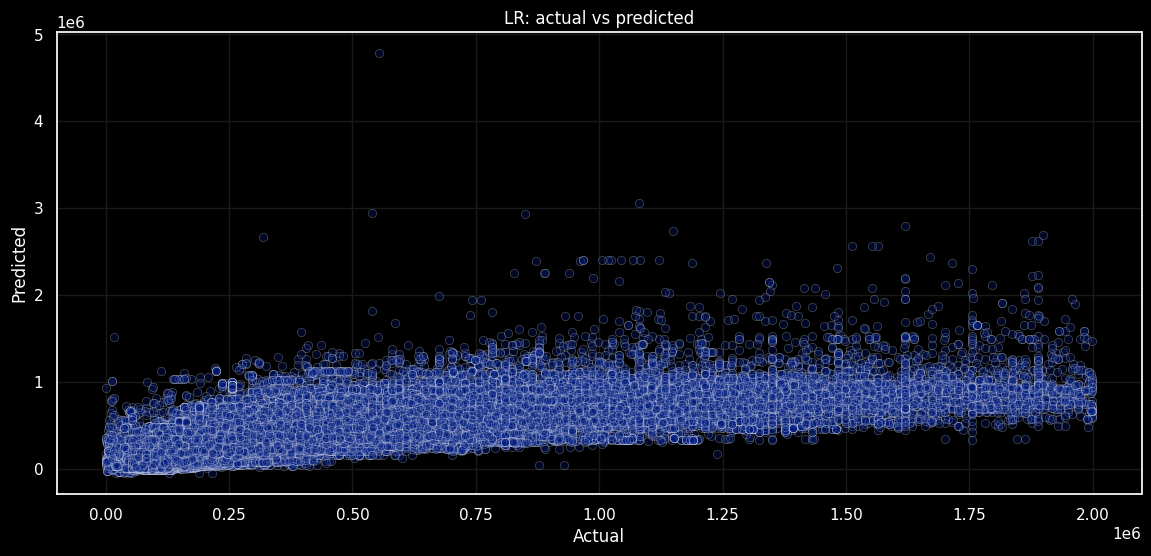

In [15]:
# cell 3b - sklearn linear regression (on preprocessed matrices)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print_metrics(y_test, y_pred_lr, prefix="LR (USD)")
# examine residuals
plt.figure(figsize=(14,6))
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.3)
plt.xlabel('Actual', color='white'); plt.ylabel('Predicted', color='white')
plt.title('LR: actual vs predicted')

In [14]:
lr_log = LinearRegression()
lr_log.fit(X_train, y_train_log)
y_pred_log = lr_log.predict(X_test)
y_pred_lr_back = np.expm1(y_pred_log)  # invert log1p -> expm1
print_metrics(y_test, y_pred_lr_back, prefix="LR (log-backtransformed USD)")

LR (log-backtransformed USD) RMSE: 2,175,525.30
LR (log-backtransformed USD) MAE : 126,345.30
LR (log-backtransformed USD) R2  : -51.9164


### Polynomial regression (capture non-linear size effects)

In [ ]:
# cell 4b - polynomial features (area^2) with proper preprocessing
train_copy = train_df.copy()
test_copy = test_df.copy()

# Create squared area feature
train_copy['area_sq'] = train_copy['procedure_area_sqm'] ** 2
test_copy['area_sq'] = test_copy['procedure_area_sqm'] ** 2

# Define numeric and categorical features
num_features_poly = ['procedure_area_sqm', 'area_sq', 'rooms_num', 'year', 'month']
bin_features = ['has_parking']
cat_features = ['area_top20', 'lm_top10', 'mall_top10']

# Column transformer for polynomial LR
preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imp', SimpleImputer(strategy='median')), 
            ('sc', StandardScaler())
        ]), num_features_poly + bin_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

# Fit and transform training and test sets
Xtr_poly = preprocessor_poly.fit_transform(train_copy[num_features_poly + bin_features + cat_features])
Xte_poly = preprocessor_poly.transform(test_copy[num_features_poly + bin_features + cat_features])

# Fit polynomial Linear Regression
lr_poly = LinearRegression()
lr_poly.fit(Xtr_poly, train_copy['actual_worth_usd'])

# Predict and evaluate
y_pred_poly = lr_poly.predict(Xte_poly)
print_metrics(test_copy['actual_worth_usd'], y_pred_poly, prefix="Poly(deg2) LR")

Poly(deg2) LR RMSE: 176,743.72
Poly(deg2) LR MAE : 117,507.35
Poly(deg2) LR R2  : 0.6507


### Regression Tree

DecisionTree RMSE: 175,500.12
DecisionTree MAE : 112,353.08
DecisionTree R2  : 0.6556


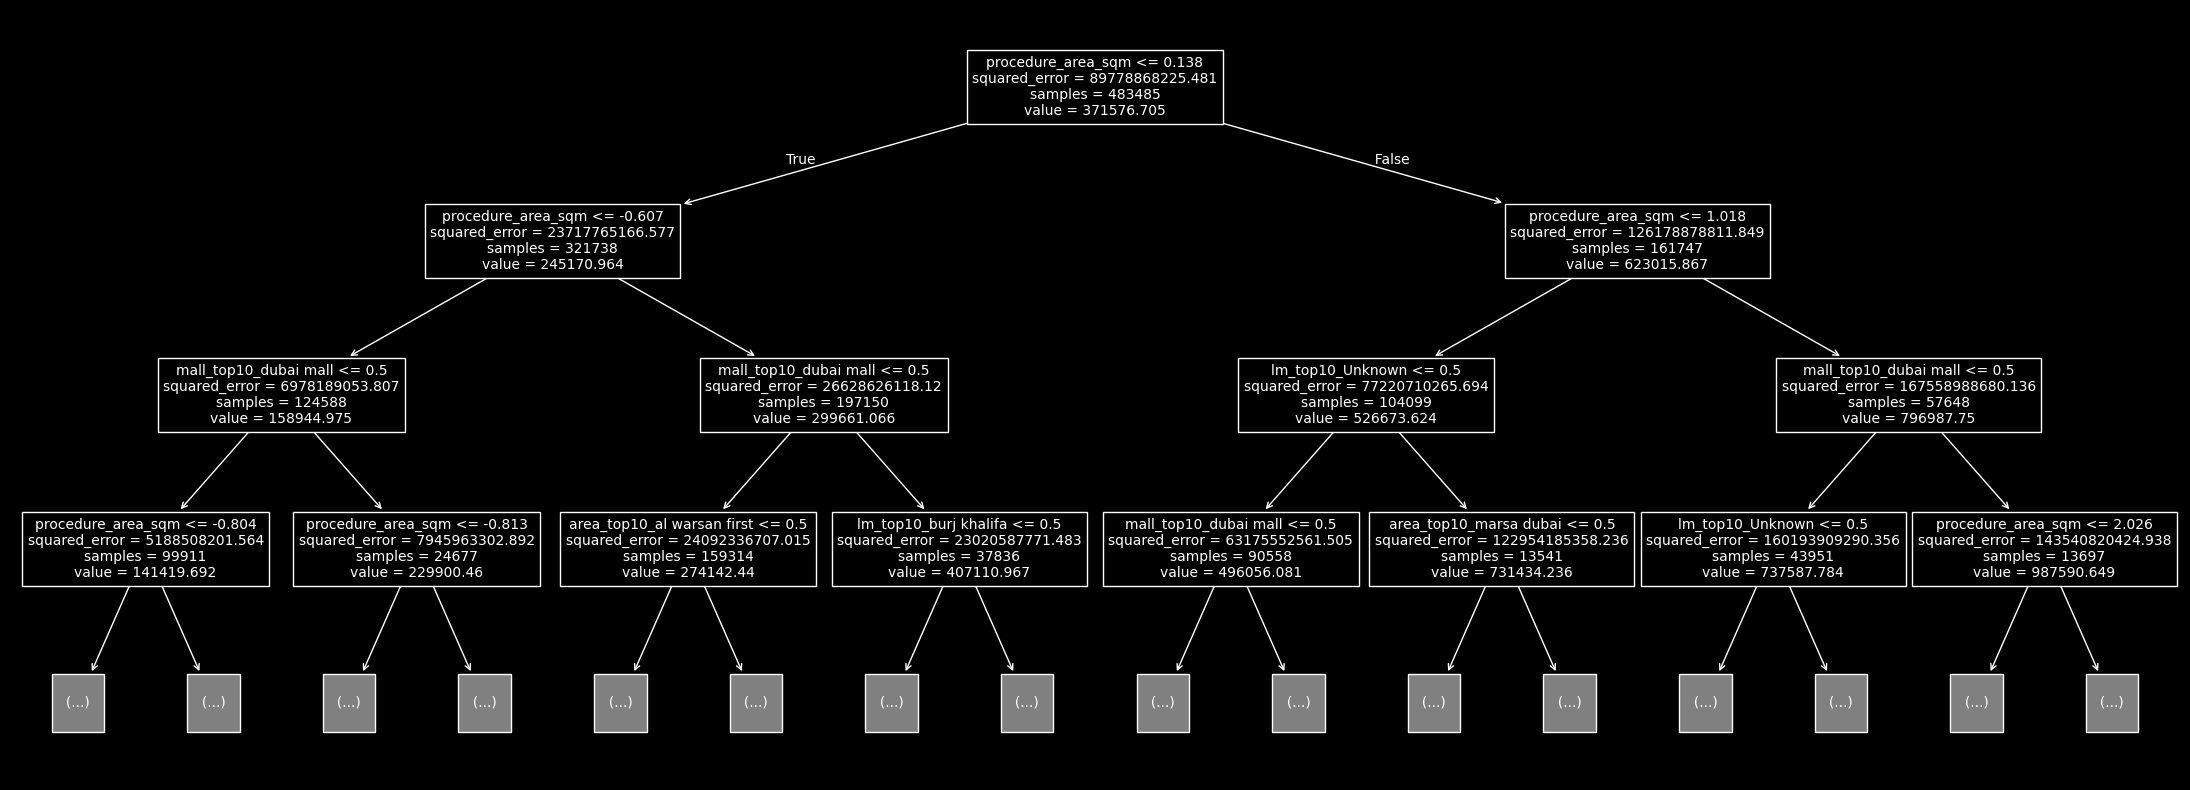

In [17]:
# cell 5 - regression tree
tree = DecisionTreeRegressor(max_depth=6, min_samples_leaf=200, random_state=RND)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)
print_metrics(y_test, y_pred_tree, prefix="DecisionTree")

# Plot (requires feature names from preprocessor)
feature_names = preprocessor.get_feature_names_out()
plt.figure(figsize=(28,10))
plot_tree(tree, feature_names=feature_names, max_depth=3, fontsize=10)
plt.show()

In [ ]:

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 14), dpi=180)
plot_tree(
    y_pred_tree,
    feature_names=feature_names,
    filled=True,        # color nodes by impurity/value
    rounded=True,       # nicer boxes
    precision=1,        # fewer decimals
    max_depth=None      # show full depth
)
plt.tight_layout()
plt.show()


RandomForest RMSE: 136,273.26
RandomForest MAE : 81,205.72
RandomForest R2  : 0.7924


Text(0.5, 1.0, 'RF top features')

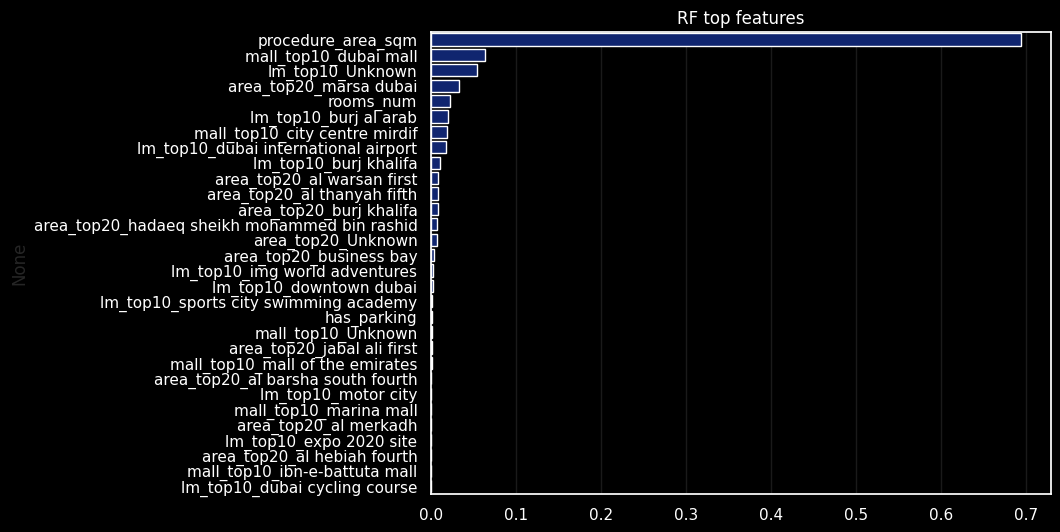

In [93]:
# cell 6 - Random Forest
rf = RandomForestRegressor(n_estimators=150, max_depth=20, n_jobs=-1, random_state=RND, min_samples_leaf=50)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print_metrics(y_test, y_pred_rf, prefix="RandomForest")

# Feature importance
importances = rf.feature_importances_
feat_names = preprocessor.get_feature_names_out()
fi = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(30)
plt.figure(figsize=(8,6)); sns.barplot(x=fi.values, y=fi.index); plt.title("RF top features")

In [94]:
# cell 7 - boosting (xgboost) if available
import xgboost as xgb

if xgb is not None:
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    params = {
        "objective":"reg:squarederror", "eta":0.05, "max_depth":6, "subsample":0.8, "colsample_bytree":0.6, "seed":RND
    }
    bst = xgb.train(params, dtrain, num_boost_round=500, evals=[(dtrain,'train')], early_stopping_rounds=20, verbose_eval=50)
    y_pred_xgb = bst.predict(dtest)
    print_metrics(y_test, y_pred_xgb, prefix="XGBoost")

[0]	train-rmse:290838.07058
[50]	train-rmse:165530.68293
[100]	train-rmse:157883.99705
[150]	train-rmse:155154.47749
[200]	train-rmse:153489.75657
[250]	train-rmse:152014.53356
[300]	train-rmse:150836.39008
[350]	train-rmse:149918.72688
[400]	train-rmse:149178.80987
[450]	train-rmse:148567.59335
[499]	train-rmse:147983.33628
XGBoost RMSE: 149,367.94
XGBoost MAE : 93,206.64
XGBoost R2  : 0.7506


In [ ]:
# cell 8 - compile metrics
results = []
# fill results with prefixes and predictions we've computed
models_preds = {
    'Linear': y_pred_lr,
    'Linear_log_back': y_pred_lr_back if 'y_pred_lr_back' in locals() else None,
    'PolyLR': y_pred_poly if 'y_pred_poly' in locals() else None,
    'Tree': y_pred_tree if 'y_pred_tree' in locals() else None,
    'RF': y_pred_rf if 'y_pred_rf' in locals() else None,
    'XGB': y_pred_xgb if 'y_pred_xgb' in locals() else None,
}

for name, pred in models_preds.items():
    if pred is None: continue
    results.append({
        'model': name,
        'RMSE': rmse(y_test, pred),
        'MAE' : mean_absolute_error(y_test, pred),
        'R2'  : r2_score(y_test, pred)
    })

pd.DataFrame(results).sort_values('RMSE')

,model,RMSE,MAE,R2
4,RF,136273,81206,1
5,XGB,149368,93207,1
3,Tree,175500,112353,1
2,PolyLR,176744,117507,1
0,Linear,186383,121538,1
1,Linear_log_back,2175525,126345,-52
